### Train NNs on the toy example

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
import dama as dm
import pickle
import os
from tqdm import tqdm

from freedom.toy_model.toy_model_functions import toy_model
from freedom.toy_model.detectors import get_box_detector
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2

In [46]:
from freedom.toy_model import NNs
%aimport freedom.toy_model.NNs

import awkward as ak
import pyarrow.parquet as pq
import json

from freedom.toy_model.NNs import hit_trafo_3D, charge_trafo_3D

In [2]:
from batty import BAT_sampler, BAT, Distributions

/home/iwsatlas1/peller/batty/batty.py:6: UserWarning: Not able to use compiled modules, resulting in (very) slow import
 See https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
  warnings.warn("Not able to use compiled modules, resulting in (very) slow import\n See https://pyjulia.readthedocs.io/en/latest/troubleshooting.html")


In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
detector = get_box_detector(x=np.linspace(-20,20,5), y=np.linspace(-20,20,5), z=np.linspace(-20,20,5))

In [5]:
toy_experiment = toy_model(detector)

In [371]:
truth = np.array([2., 3, 1, 0, 2, 1, 20, 0.8])
rand = np.random.RandomState(42)
test_event = toy_experiment.generate_event(truth, rand=rand)

In [373]:
g = dm.GridData(x=np.linspace(-5, 5, 100), y=np.linspace(0, 4, 100))

In [374]:
toy_experiment.calc_analytic_llhs(g, test_event, truth);

10000it [00:35, 281.65it/s]


In [9]:
def plot_truth(axes, truth):
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for ax in axes.flatten():
        ax.plot([truth[0]], [truth[1]], marker='$T$', markersize=10, color='k')

In [10]:
def plot_diff(a, b, axes, title_a='a', title_b='b', vmax=None, limit_diff=False, **kwargs):
    
    levels = stats.chi2(df=2).isf(stats.norm.sf(np.arange(1,6))*2)/2    
    labels = [str(i) + r'$\sigma$' for i in range(1,6)]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors = plt.cm.viridis(np.linspace(0, 0.9, 6))
    #a.plot(ax=axes[0], cmap='binary', label=r'$\Delta LLH$', vmax=vmax, **kwargs)
    a.plot_contour(ax=axes[0], levels=levels, labels=labels, colors=colors, **kwargs)
    axes[0].set_title(title_a)
    #b.plot(ax=axes[1], cmap='binary', label=r'$\Delta LLH$', vmax=vmax, **kwargs)
    b.plot_contour(ax=axes[1], levels=levels,  labels=labels, colors=colors, **kwargs)
    axes[1].set_title(title_b)
    
    if len(axes) > 2:
        diff = a - b
        if limit_diff:
            diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-vmax, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
            #diff.plot_contour(ax=axes[2], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
            #np.clip(-diff, 0, None).plot_contour(ax=axes[2], levels=[0.1,0.2, 0.3], colors=['r']*2)
        else:
            diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), label=r'$\Delta LLH$', **kwargs) 
            #diff.plot_contour(ax=axes[2], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
        axes[2].set_title(title_a + ' - ' + title_b)

Text(0.5, 0, 'x (m)')

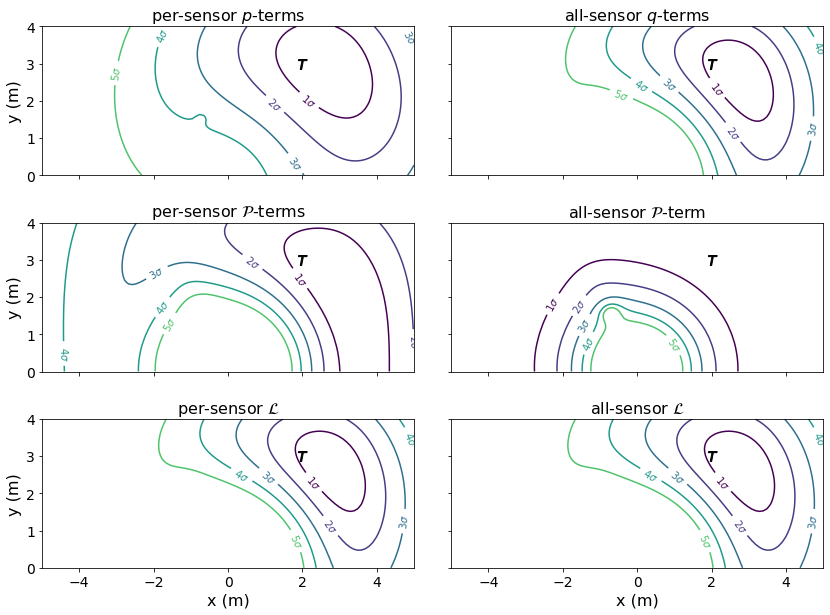

In [375]:
fig, ax = plt.subplots(3, 2, figsize=(14,10), sharex=True, sharey=True)

for axis in ax.flatten():
    axis.set_aspect("equal")

plt.subplots_adjust(wspace=0.1, hspace=0.3)

plot_diff(g['per_dom_hit_term'], g['all_dom_charge_hit_terms'], axes=ax[0], title_a=r'per-sensor $p$-terms', title_b=r'all-sensor $q$-terms', vmax=100, limit_diff=True)
plot_diff(g['per_dom_charge_terms'], g['all_dom_charge_terms'], axes=ax[1], title_a='per-sensor $\mathcal{P}$-terms', title_b=r'all-sensor $\mathcal{P}$-term', vmax=100, limit_diff=True)
plot_diff(g['per_dom_llh'], g['all_dom_charge_llh'], axes=ax[2], title_a=r'per-sensor $\mathcal{L}$', title_b=r'all-sensor $\mathcal{L}$', limit_diff=False, vmax=100)

plot_truth(ax, truth)

ax[0,0].set_xlabel('')
ax[1,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,1].set_xlabel('')
[ax[i,1].set_ylabel('') for i in range(3)];
[ax[i,0].set_ylabel('y (m)') for i in range(3)];
ax[2,0].set_xlabel('x (m)')
ax[2,1].set_xlabel('x (m)')


#plt.savefig('sensor_vs_global.pdf', bbox_inches='tight')
#plt.savefig('sensor_vs_global.png', bbox_inches='tight')

## Generate Events

In [38]:
events, meta = toy_experiment.generate_events(n=1_000_000,
                               gamma=0,
                               gen_volume="box",
                               e_lim=(5,100),
                               x_lim=(-30,30),
                               y_lim=(-30,30),
                               z_lim=(-30,30),
                               inelast_lim=(0,1),
                               t_width=0,
                               contained=True,
                               min_hits=3,
                               rand=0,
                               outfile='1M_toy_events.parquet')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [13:07<00:00, 1269.90it/s]


In [362]:
events, meta = toy_experiment.generate_events(n=10_000,
                               gamma=0,
                               gen_volume="box",
                               e_lim=(1,100),
                               padding=0.25,
                               inelast_lim=(0,1),
                               t_width=0,
                               contained=True,
                               min_hits=3,
                               rand=0,
                               outfile='10k_toy_events_example.parquet')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1058.19it/s]


In [363]:
test = ak.from_parquet('10k_toy_events_example.parquet')

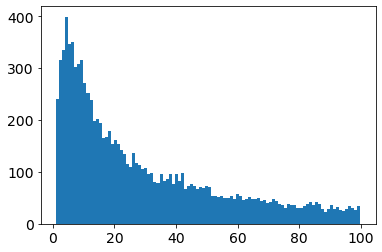

In [364]:
plt.hist(test.mc_truth.energy, bins=100);

In [368]:
events.photons

<Array [{x: [-10, -10, -10, ... 122, 123]}] type='10000 * {"x": var * float64, "...'>

In [238]:
events = ak.from_parquet('1M_toy_events.parquet')

In [365]:
json.loads(pq.read_schema('10k_toy_events_example.parquet').metadata['config_freedom'.encode()].decode())

{'generator': {'rand': 0,
  'gen_volume': 'box',
  'x_lim': [-30.0, 30.0],
  'y_lim': [-30.0, 30.0],
  'z_lim': [-30.0, 30.0],
  'n': 10000,
  'gamma': 0,
  'e_lim': [1, 100],
  'inelast_lim': [0, 1],
  't_width': 0,
  'min_hits': 3,
  'contained': True},
 'env': {'user': 'peller',
  'system': 'Linux odslserv01 5.13.0-35-generic #40~20.04.1-Ubuntu SMP Mon Mar 7 09:18:32 UTC 2022 x86_64'},
 'experiment': {'lambda_a': 100,
  'lambda_s': 30,
  'tau': 500,
  'n_ref': 1.3,
  'c': 0.3,
  's': 10,
  'trck_e_to_l': 4.5,
  'ns_per_trck_m': 2451,
  'ns_per_cscd_gev': 12819,
  'noise_level': 1e-10,
  'r_pmt': 0.1,
  'q_eff': 0.3,
  'track_step': 1}}

In [185]:
c = events.n_obs.to_numpy()

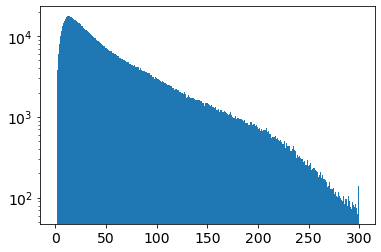

In [186]:
plt.hist(ak.count(events.photons.t, axis=1).to_numpy(), bins=np.linspace(0,300,300));
plt.gca().set_yscale("log")

# Train NNs

## Hit Net

In [252]:
x, t = NNs.get_hit_data(events)
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1, random_state=42)
d_train = NNs.DataGenerator(x_train, t_train, batch_size=2**14)
d_valid = NNs.DataGenerator(x_test, t_test, batch_size=2**14)

In [ ]:
hmodel = NNs.get_hmodel(x_shape=x.shape[1], t_shape=t.shape[1], trafo=NNs.hit_trafo_3D, activation='swish')

In [265]:
optimizer = tf.keras.optimizers.Adam(1e-5)
hmodel.compile(loss='binary_crossentropy', optimizer=optimizer)

In [266]:
hist = hmodel.fit(d_train, epochs=4, verbose=1, validation_data=d_valid)

Epoch 1/4
6884/6884 [==============================] - 85s 12ms/step - loss: 0.3897 - val_loss: 0.3898
Epoch 2/4
6884/6884 [==============================] - 81s 12ms/step - loss: 0.3896 - val_loss: 0.3898
Epoch 3/4
6884/6884 [==============================] - 80s 12ms/step - loss: 0.3895 - val_loss: 0.3894
Epoch 4/4
6884/6884 [==============================] - 86s 12ms/step - loss: 0.3895 - val_loss: 0.3896


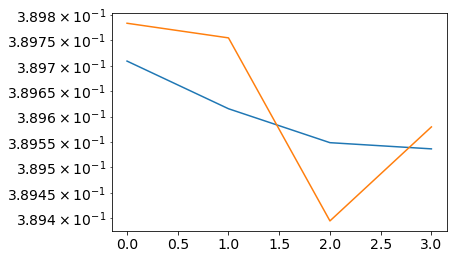

In [267]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

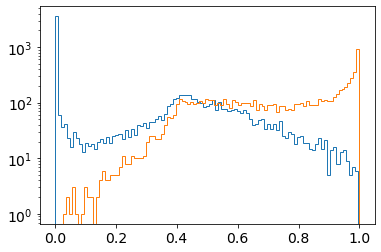

In [268]:
inp, lab = d_valid.__getitem__(0)
pred = hmodel.predict(inp, batch_size=4096).flatten()
plt.hist(pred[lab==0], 100, histtype='step')
plt.hist(pred[lab==1], 100, histtype='step');
plt.yscale('log')

In [269]:
hmodel.save('networks/deepcore_toy_hitnet_total.h5')

In [270]:
hitnet = tf.keras.models.clone_model(hmodel)
hitnet.layers[-1].activation = tf.keras.activations.linear
hitnet.compile()
hitnet.set_weights(hmodel.get_weights())

## Charge Net

In [198]:
x, t = NNs.get_charge_data(events)
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1, random_state=42)

d_train = NNs.DataGenerator(x_train, t_train, batch_size=4096)
d_valid = NNs.DataGenerator(x_test, t_test, batch_size=4096)

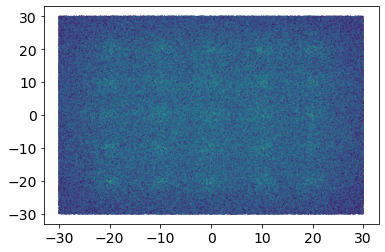

In [199]:
plt.scatter(t_train[:,0], t_train[:,1], s=0.1, c=np.log(x_train[:,0]))

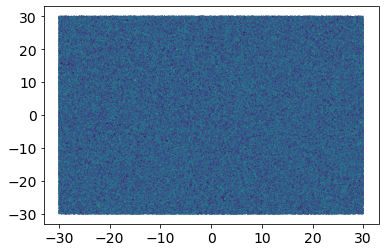

In [200]:
plt.scatter(t_train[:,0], t_train[:,1], s=0.1, c=np.log(np.random.permutation(x_train[:,0])))

In [202]:
cmodel = NNs.get_cmodel(x_shape=x.shape[1], t_shape=t.shape[1], trafo=NNs.charge_trafo_3D, activation='swish', final_activation='swish') #, n_layers=16, n_nodes=128)

In [203]:
optimizer = tf.keras.optimizers.Adam(1e-3)
cmodel.compile(loss='binary_crossentropy', optimizer=optimizer)

In [204]:
hist = cmodel.fit(d_train, epochs=100, verbose=1, validation_data=d_valid)

Epoch 1/100
439/439 [==============================] - 4s 8ms/step - loss: 0.3650 - val_loss: 0.3201
Epoch 2/100
439/439 [==============================] - 3s 8ms/step - loss: 0.3136 - val_loss: 0.3065
Epoch 3/100
439/439 [==============================] - 3s 8ms/step - loss: 0.3019 - val_loss: 0.2959
Epoch 4/100
439/439 [==============================] - 3s 7ms/step - loss: 0.2985 - val_loss: 0.2944
Epoch 5/100
439/439 [==============================] - 3s 7ms/step - loss: 0.2960 - val_loss: 0.2949
Epoch 6/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2940 - val_loss: 0.2961
Epoch 7/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2922 - val_loss: 0.2889
Epoch 8/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2916 - val_loss: 0.2939
Epoch 9/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2899 - val_loss: 0.2892
Epoch 10/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2885 - val_lo

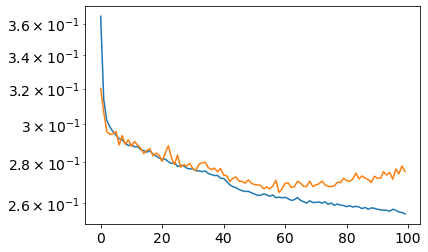

In [205]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

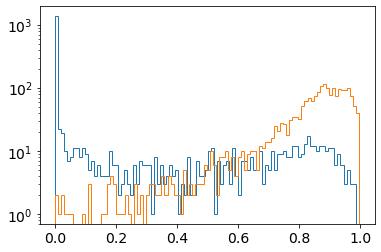

In [206]:
inp, lab = d_valid.__getitem__(0)
pred = cmodel.predict(inp, batch_size=4096).flatten()
plt.hist(pred[lab==0], 100, histtype='step')
plt.hist(pred[lab==1], 100, histtype='step');
plt.yscale('log')

In [207]:
cmodel.save('networks/deepcore_toy_chargenet_total.h5')

In [208]:
chargenet = tf.keras.models.clone_model(cmodel)
chargenet.set_weights(cmodel.get_weights())
chargenet.layers[-1].activation = tf.keras.activations.linear
chargenet.compile()

In [209]:
def plot_overlay(a, b, ax, **kwargs):
    levels = stats.chi2(df=2).isf(stats.norm.sf(np.arange(1,6))*2)/2    
    labels = [str(i) + r'$\sigma$' for i in range(1,6)]
    colors = plt.cm.viridis(np.linspace(0, 0.9, 6))
    a.plot_contour(ax=ax, levels=levels, labels=labels, colors=colors, **kwargs)
    b.plot_contour(ax=ax, levels=levels,  linestyles=[':']*len(levels), colors=colors, **kwargs)


In [378]:
g = dm.GridData(x=np.linspace(-5, 5, 100), y=np.linspace(-5, 5, 100))

In [379]:
toy_experiment.calc_analytic_llhs(g, test_event, truth);

10000it [00:35, 281.87it/s]


In [380]:
toy_experiment.calc_NN_llhs(g, test_event, truth, chargenet, hitnet);

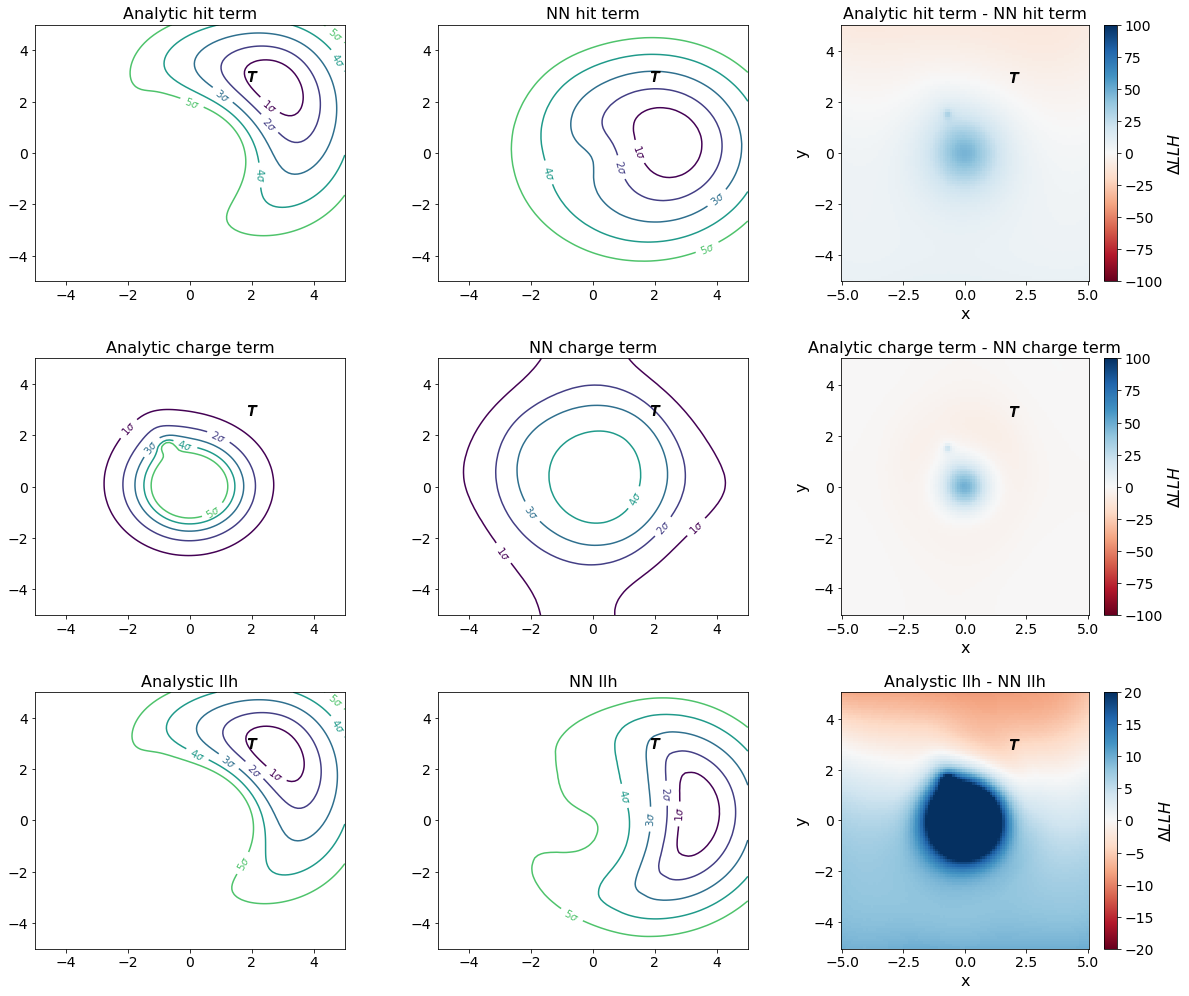

In [381]:
fig, ax = plt.subplots(3, 3, figsize=(20,17))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plot_diff(g['all_dom_charge_hit_terms'], g.hitnet_llh, axes=ax[0], title_a='Analytic hit term', title_b='NN hit term', vmax=100, limit_diff=True)
plot_diff(g['all_dom_charge_terms'], g.chargenet_llh, axes=ax[1], title_a='Analytic charge term', title_b='NN charge term', vmax=100, limit_diff=True)
plot_diff(g.all_dom_charge_llh, g.freedom_llh, axes=ax[2], title_a='Analystic llh', title_b='NN llh', vmax=20, limit_diff=True)

plot_truth(ax, truth)

In [382]:
g1 = dm.GridData(energy = np.linspace(1,100,100))
toy_experiment.calc_analytic_llhs(g1, test_event, truth);
toy_experiment.calc_NN_llhs(g1, test_event, truth, chargenet, hitnet);

100it [00:00, 212.30it/s]


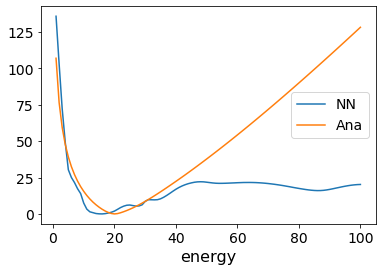

In [383]:
g1.freedom_llh.plot(label='NN')
g1.all_dom_charge_llh.plot(label='Ana')
plt.legend()

In [281]:
# g = dm.GridData(x = np.linspace(-10,10,30), y=np.linspace(-10,10,30))
# toy_experiment.calc_analytic_llhs(g, test_event, truth);
# toy_experiment.calc_NN_llhs(g, test_event, truth, chargenet, hitnet);

900it [00:02, 321.18it/s]


Text(0.5, 1.0, 'Ana')

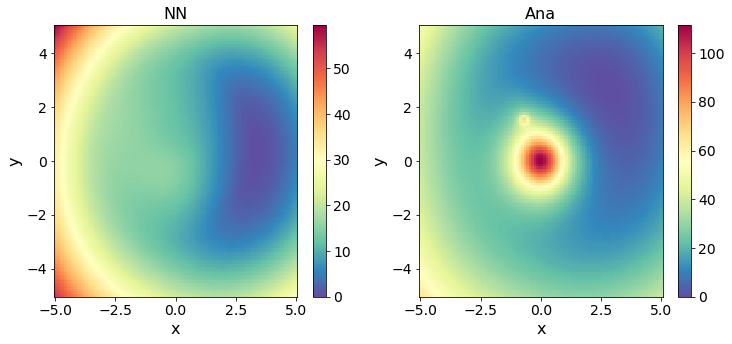

In [384]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

g.freedom_llh.plot(ax=ax[0], cmap=plt.cm.Spectral_r, cbar=True)
g.all_dom_charge_llh.plot(ax=ax[1], cmap=plt.cm.Spectral_r, cbar=True)

ax[0].set_title('NN')
ax[1].set_title('Ana')

# MCMC

In [515]:

hitnet = tf.keras.models.load_model('networks/deepcore_toy_hitnet_total.h5',
                                 custom_objects={'hit_trafo_3D':NNs.hit_trafo_3D})
hitnet.layers[-1].activation = tf.keras.activations.linear
hitnet.compile()

chargenet = tf.keras.models.load_model('networks/deepcore_toy_chargenet_total.h5',
                                 custom_objects={'charge_trafo_3D':NNs.charge_trafo_3D})
chargenet.layers[-1].activation = tf.keras.activations.linear
chargenet.compile()

In [297]:
def llh(p, test_event, chargenet, hitnet):
    xxs = np.array([np.sum(test_event[1]), np.sum(test_event[1]>0)])[np.newaxis, :]
    tts = p[np.newaxis, :]
    c_llh = chargenet((xxs, tts))[0,0].numpy()

    xxs = test_event[0][:, :4]
    tts = np.repeat(p[np.newaxis, :], len(test_event[0]), axis=0)
    h_llhs = hitnet((xxs, tts)).numpy()
    h_llh = np.nan_to_num(np.sum(h_llhs))

    return c_llh + h_llh

In [385]:
priors = {}
priors['x'] = Distributions.Uniform(-25, 25)
priors['y'] = Distributions.Uniform(-25, 25)
priors['z'] = Distributions.Uniform(-25, 25)
priors['az'] = Distributions.Uniform(0, 2*np.pi)
priors['zen'] = Distributions.Uniform(0, np.pi)
priors['log_energy'] = Distributions.Uniform(0,2)
priors['inelast'] = Distributions.Uniform(0,1)

In [388]:
def bat_llh_ana(x):
    p = np.copy(truth)
    p[0] = x.x
    p[1] = x.y
    p[2] = x.z
    p[4] = x.az
    p[5] = x.zen
    p[6] = 10.**x.log_energy
    p[7] = x.inelast
    l = -toy_experiment.nllh(p, *test_event)
    #print(l)
    return l

In [389]:
def bat_llh(x):
    p = np.copy(truth)
    p[0] = x.x
    p[1] = x.y
    p[2] = x.z
    p[4] = x.az
    p[5] = x.zen
    p[6] = 10.**x.log_energy * x.inelast
    p[7] = 10.**x.log_energy * (1 - x.inelast)
    l = llh(p, test_event, chargenet, hitnet)
    #print(l)
    return l

In [286]:
from collections import namedtuple

In [390]:
p_type = namedtuple('p', ['x', 'y', 'z', 'az', 'zen', 'log_energy', 'inelast'])
test_p = p_type(x=0, y=0, z=0, az=0, zen=0, log_energy=1, inelast=0)

In [391]:
bat_llh(test_p)

-14.712222

In [392]:
bat_llh_ana(test_p)

-987.9109943399629

In [393]:
sampler = BAT_sampler(bat_llh, priors)

In [394]:
sampler_ana = BAT_sampler(bat_llh_ana, priors)

In [ ]:
%%time
sampler.run(nsteps=1e5, nchains=2);

[ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
[ Info: Using transform algorithm BAT.PriorSubstitution()
[ Info: Trying to generate 2 viable MCMC chain(s).
[ Info: Selected 2 MCMC chain(s).
[ Info: Begin tuning of 2 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 2 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 2 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 2 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 4 finished, 2 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 5 finished, 2 chains, 1 tuned, 0 converged.
[ Info: MCMC Tuning cycle 6 finished, 2 chains, 1 tuned, 0 converged.
[ Info: MCMC Tuning cycle 7 finished, 2 chains, 1 tuned, 2 converged.
[ Info: MCMC Tuning cycle 8 finished, 2 chains, 1 tuned, 2 converged.
[ Info: MCMC Tuning cycle 9 finished, 2 chains, 2 tuned, 2 converged.
[ Info: MCMC tuning of 2 chains successful after 9 cycle(s).
[ Info: Running post-tuning stabilization steps for 2 MCM

In [ ]:
%%time
sampler_ana.run(nsteps=1e5, nchains=2);

In [309]:
sampler_ana.result.samples

result_tuple(x=array([0.69385788, 1.53953367, 2.90416199, ..., 1.13668972, 1.32834526,
       1.80419093]), y=array([3.67508376, 3.45626516, 3.13620604, ..., 3.21920334, 2.94582968,
       2.85948465]), z=array([-0.63289517, -0.35428613, -0.29569166, ..., -0.43043055,
        0.3359452 ,  0.43459946]), az=array([4.00361072, 3.90240771, 3.27213769, ..., 4.53184355, 5.04614427,
       5.10994541]), zen=array([1.74926822, 1.86763889, 1.40383818, ..., 2.63109241, 1.94049944,
       2.29797801]), energy=array([22.25581275, 23.85102378, 29.98340535, ..., 17.44213386,
       23.90301864, 28.48438722]), inelast=array([0.71483652, 0.75585467, 0.53739375, ..., 0.71466801, 0.58216866,
       0.4950379 ]))

In [310]:
from corner import corner

In [311]:
sampler.result.samples._fields

('x', 'y', 'z', 'az', 'zen', 'energy', 'inelast')

In [312]:
labels = ['x (m)', 'y (m)', 'z (m)', r'Azimuth (rad)', r'Zenith (rad)', 'Energy (GeV)', 'Inelasticity']

In [313]:
truth

array([ 2. ,  3. ,  1. ,  0. ,  2. ,  1. , 20. ,  0.9])

In [315]:
true_vals = np.copy(truth)[:7]

In [316]:
true_vals[3:7] = truth[4:]

In [317]:
#true_vals[-2] = 20
#true_vals[-1] = 0.9

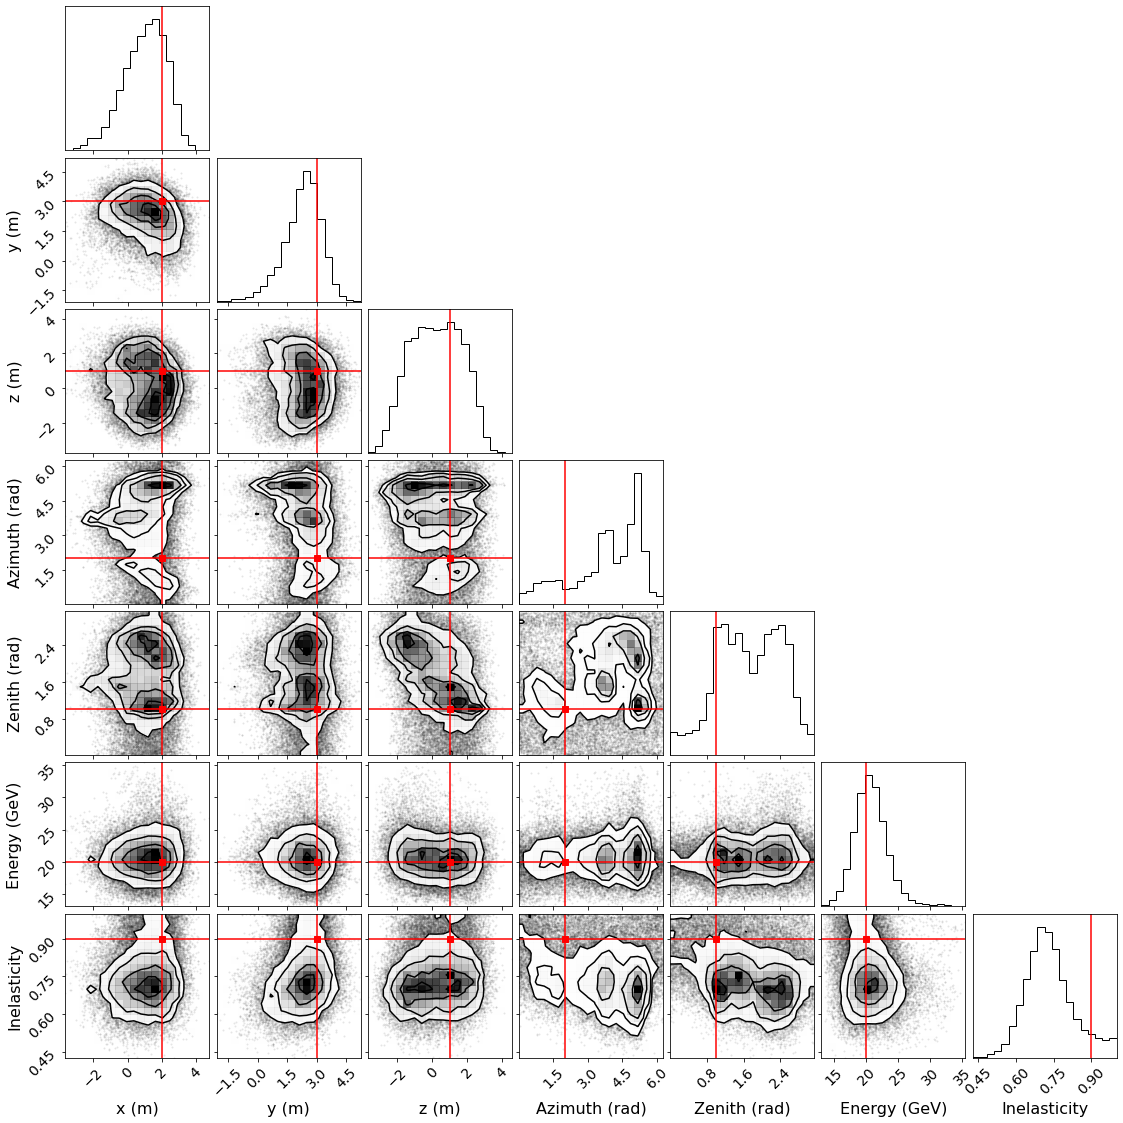

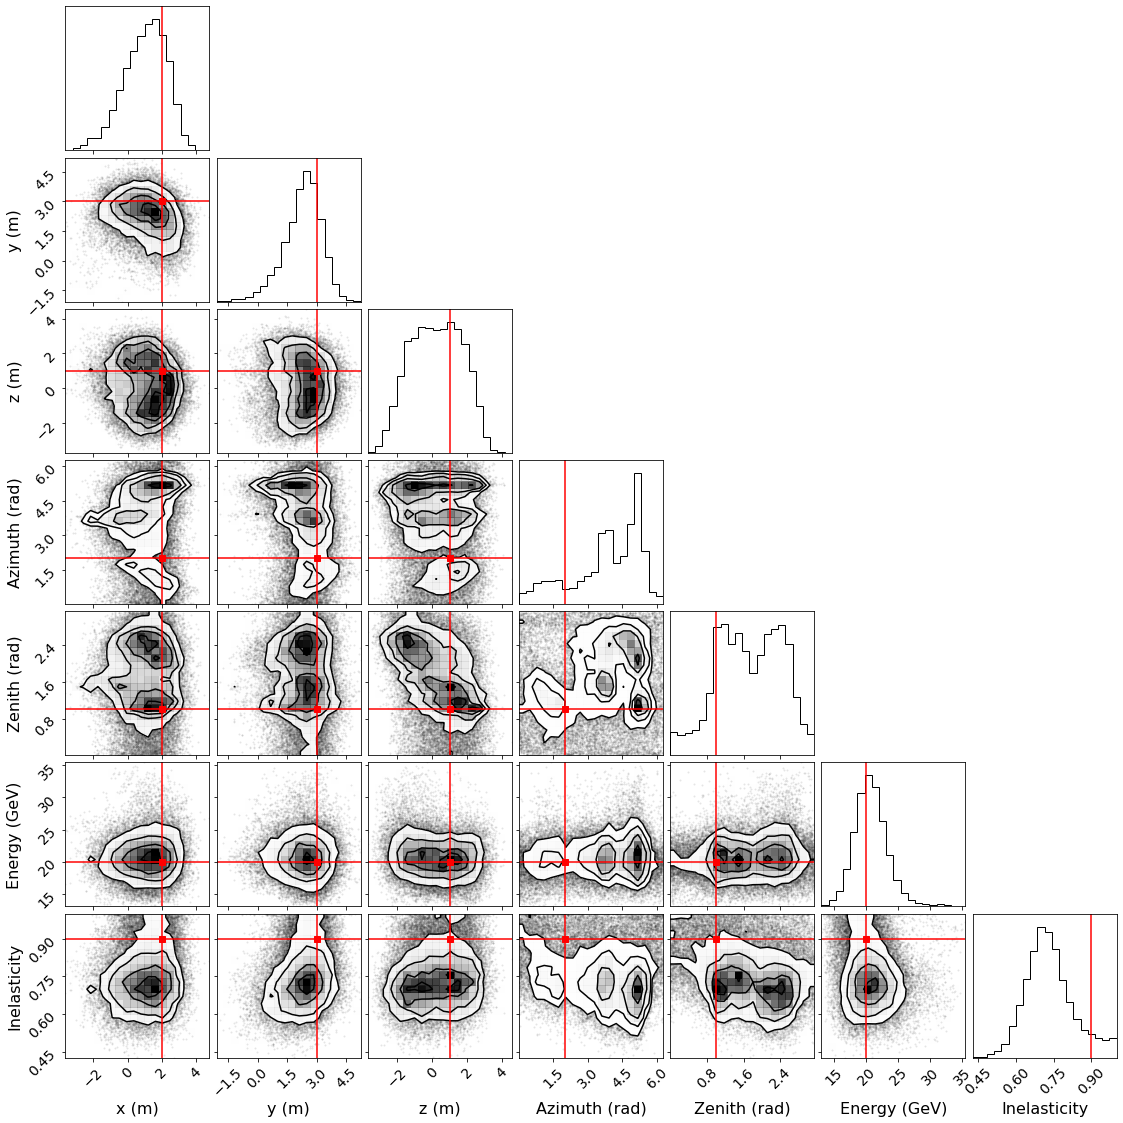

In [319]:
corner(np.stack(sampler.result.samples).T, labels=labels, weights=sampler.result.weight, truths=true_vals, truth_color='r')
#plt.savefig('MCMC_7d_test.jpg')

In [321]:
import pygtc

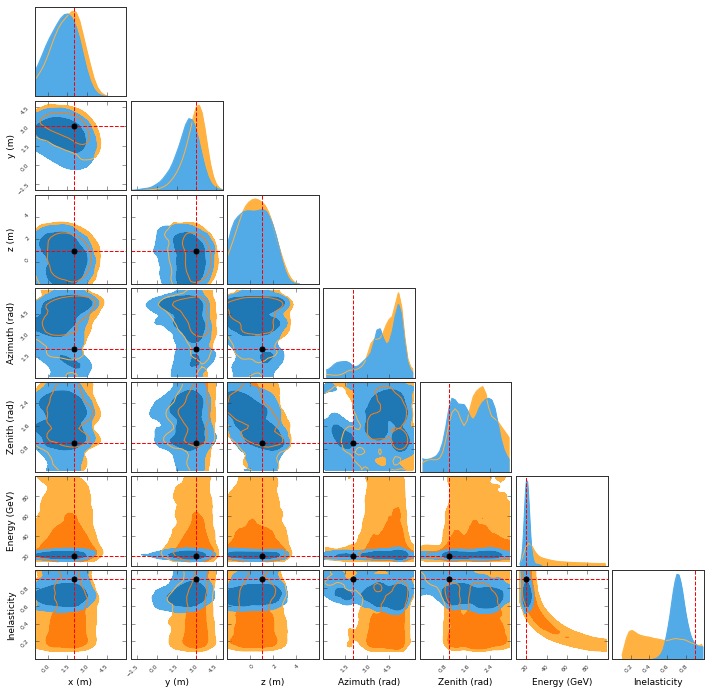

In [323]:
fig = pygtc.plotGTC(chains=[np.stack(sampler.result.samples).T, np.stack(sampler_ana.result.samples).T], truthColors='r',
              weights=[sampler.result.weight, sampler_ana.result.weight],
              paramNames=labels,
              truths=true_vals,
              figureSize=12,
              nContourLevels=2,
              paramRanges=[(-1, 6), (-2, 5), (-2, 6), (0, 2*np.pi), (0, np.pi), (10, 100), (0, 1)],
              panelSpacing='loose')

mod = 1
m = 0
i = 0
for n in range(len(fig.axes)-7):
    j = m % mod
    fig.axes[n].plot(true_vals[j], true_vals[i+1], '.', ms=10, c='k')
    if j == mod - 1:
        mod += 1
        m = 0
        i += 1
    else:
        m += 1
#fig.savefig('MCMC_7d_test_kde.jpg', dpi=200, bbox_inches='tight')

In [ ]:
Distributions.